In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go


### Load and Prepare the Data


In [56]:
# Load the dataset
data = pd.read_csv('train.csv')

# Select features and target
# Let's use 'GrLivArea' (Above grade living area) as our feature and 'SalePrice' as target
X = data['GrLivArea'].values.reshape(-1, 1)
y = data['SalePrice'].values.reshape(-1, 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add bias term (intercept)
X_train_scaled = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_scaled = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

###  Implement Linear Regression with SGD

In [64]:
class LinearRegressionSGD:
    def __init__(self, learning_rate=0.01, n_epochs=100, batch_size=32, loss='mse'):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.loss = loss
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _compute_loss(self, y_true, y_pred):
        if self.loss == 'mse':
            return np.mean((y_true - y_pred) ** 2)
        elif self.loss == 'mae':
            return np.mean(np.abs(y_true - y_pred))
        elif self.loss == 'huber':
            delta = 1.0
            error = y_true - y_pred
            is_small_error = np.abs(error) <= delta
            squared_loss = 0.5 * (error ** 2)
            linear_loss = delta * (np.abs(error) - 0.5 * delta)
            return np.mean(np.where(is_small_error, squared_loss, linear_loss))
        else:
            raise ValueError("Unsupported loss function")
    
    def _compute_gradient(self, X_batch, y_batch, y_pred):
        error = y_pred - y_batch
        if self.loss == 'mse':
            grad = X_batch.T.dot(error) / len(X_batch)
        elif self.loss == 'mae':
            grad = X_batch.T.dot(np.sign(error)) / len(X_batch)
        elif self.loss == 'huber':
            delta = 1.0
            abs_error = np.abs(error)
            is_small_error = abs_error <= delta
            grad = np.where(
                is_small_error,
                X_batch.T.dot(error) / len(X_batch),
                delta * X_batch.T.dot(np.sign(error)) / len(X_batch)
            )
        return grad
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros((n_features, 1))
        
        for epoch in range(self.n_epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                # Predictions
                y_pred = X_batch.dot(self.weights)
                
                # Compute loss
                batch_loss = self._compute_loss(y_batch, y_pred)
                epoch_loss += batch_loss
                
                # Compute gradients
                gradients = self._compute_gradient(X_batch, y_batch, y_pred)
                
                # Update weights
                self.weights -= self.learning_rate * gradients
            
            # Store average epoch loss
            avg_epoch_loss = epoch_loss / (n_samples / self.batch_size)
            self.loss_history.append(avg_epoch_loss)
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{self.n_epochs}, Loss: {avg_epoch_loss:.4f}")
    
    def predict(self, X):
        return X.dot(self.weights)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        return mse, mae, r2

## Train and Evaluate the Model


In [66]:
# Initialize and train the model
model = LinearRegressionSGD(learning_rate=0.01, n_epochs=100, batch_size=32, loss='mse')
model.fit(X_train_scaled, y_train)

# Evaluate on test set
mse, mae, r2 = model.evaluate(X_test_scaled, y_test)
print(f"\nTest MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R-squared: {r2:.4f}")

Epoch 10/100, Loss: 3135748412.5031
Epoch 20/100, Loss: 3126738106.1268
Epoch 30/100, Loss: 3106867597.3947
Epoch 40/100, Loss: 3137433454.6144
Epoch 50/100, Loss: 3134084434.7613
Epoch 60/100, Loss: 3109476208.7812
Epoch 70/100, Loss: 3117883292.5406
Epoch 80/100, Loss: 3258896343.1241
Epoch 90/100, Loss: 3090056664.9220
Epoch 100/100, Loss: 3117657193.3915


NameError: name 'mean_squared_error' is not defined

### Visualize the raw data (before training)

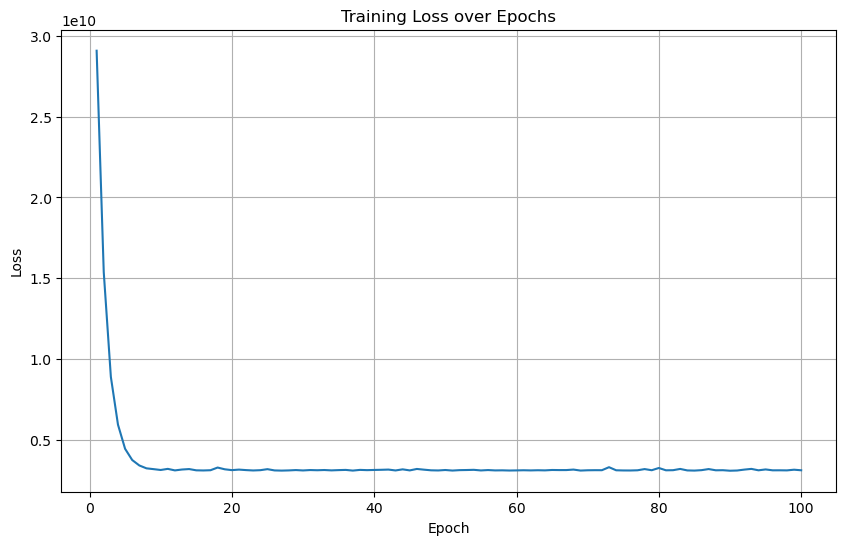

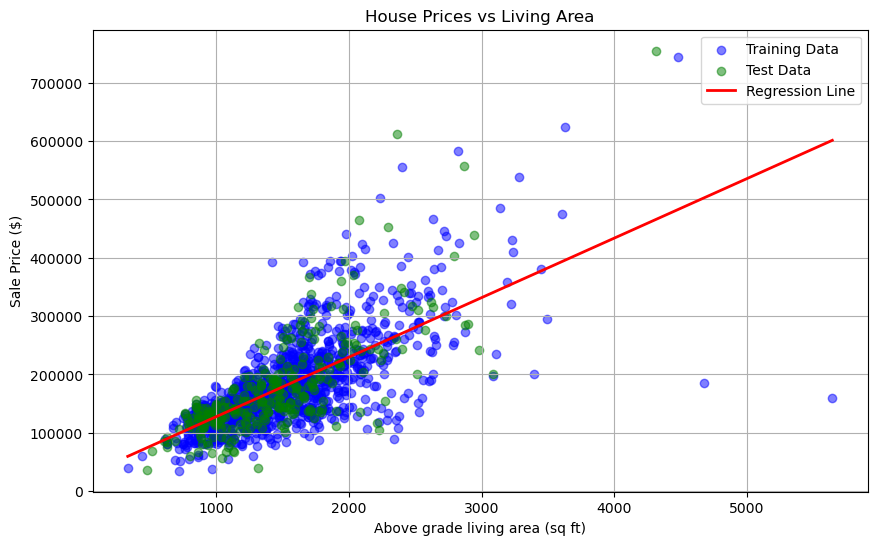

In [68]:
import plotly.express as px
# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(model.loss_history)+1), model.loss_history)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.5)
plt.scatter(X_test, y_test, color='green', label='Test Data', alpha=0.5)

# Create line for predictions
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_line_scaled = scaler.transform(x_line)
x_line_scaled = np.c_[np.ones((x_line_scaled.shape[0], 1)), x_line_scaled]
y_line = model.predict(x_line_scaled)

plt.plot(x_line, y_line, color='red', linewidth=2, label='Regression Line')
plt.title('House Prices vs Living Area')
plt.xlabel('Above grade living area (sq ft)')
plt.ylabel('Sale Price ($)')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparameter Tuning


In [87]:
class LinearRegressionSGD:
    def __init__(self, learning_rate=0.01, n_epochs=100, batch_size=32, loss='mse'):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.loss = loss
        self.weights = None
        self.loss_history = []
        
    def _compute_loss(self, y_true, y_pred):
        if self.loss == 'mse':
            return np.mean((y_true - y_pred) ** 2)
        elif self.loss == 'mae':
            return np.mean(np.abs(y_true - y_pred))
        elif self.loss == 'huber':
            delta = 1.0
            error = y_true - y_pred
            is_small_error = np.abs(error) <= delta
            squared_loss = 0.5 * (error ** 2)
            linear_loss = delta * (np.abs(error) - 0.5 * delta)
            return np.mean(np.where(is_small_error, squared_loss, linear_loss))
        else:
            raise ValueError("Unsupported loss function")
    
    def _compute_gradient(self, X_batch, y_batch, y_pred):
        error = y_pred - y_batch
        if self.loss == 'mse':
            grad = X_batch.T.dot(error) / len(X_batch)
        elif self.loss == 'mae':
            grad = X_batch.T.dot(np.sign(error)) / len(X_batch)
        elif self.loss == 'huber':
            delta = 1.0
            abs_error = np.abs(error)
            is_small_error = abs_error <= delta
            grad = np.where(
                is_small_error,
                X_batch.T.dot(error) / len(X_batch),
                delta * X_batch.T.dot(np.sign(error)) / len(X_batch)
            )
        return grad
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros((n_features, 1))
        
        for epoch in range(self.n_epochs):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                # Predictions
                y_pred = X_batch.dot(self.weights)
                
                # Compute loss
                batch_loss = self._compute_loss(y_batch, y_pred)
                epoch_loss += batch_loss
                
                # Compute gradients
                gradients = self._compute_gradient(X_batch, y_batch, y_pred)
                
                # Update weights - ensure gradients are the right shape
                self.weights -= self.learning_rate * gradients.reshape(-1, 1)
            
            # Store average epoch loss
            avg_epoch_loss = epoch_loss / (n_samples / self.batch_size)
            self.loss_history.append(avg_epoch_loss)
            
            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{self.n_epochs}, Loss: {avg_epoch_loss:.4f}")
    
    def predict(self, X):
        return X.dot(self.weights)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        mse = np.mean((y - y_pred) ** 2)
        mae = np.mean(np.abs(y - y_pred))
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / (ss_tot + 1e-10))  # Added small value to avoid division by zero
        return mse, mae, r2

### Define a Simple Tuning Function

In [89]:
# Initialize and train the model
model = LinearRegressionSGD(learning_rate=0.01, n_epochs=100, batch_size=32, loss='mse')
model.fit(X_train_scaled, y_train)

# Evaluate on test set
mse, mae, r2 = model.evaluate(X_test_scaled, y_test)
print(f"\nTest MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R-squared: {r2:.4f}")

# Hyperparameter tuning
learning_rates = [0.001, 0.01, 0.1]
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    model = LinearRegressionSGD(learning_rate=lr, n_epochs=50, batch_size=32)
    model.fit(X_train_scaled, y_train)
    mse, mae, r2 = model.evaluate(X_test_scaled, y_test)
    print(f"Test MSE: {mse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

Epoch 10/100, Loss: 36570237437.4000
Epoch 20/100, Loss: 36582936989.9414
Epoch 30/100, Loss: 36448317999.9319
Epoch 40/100, Loss: 36578990511.4875
Epoch 50/100, Loss: 36530839737.0848
Epoch 60/100, Loss: 36572791652.1747
Epoch 70/100, Loss: 36575831013.7173
Epoch 80/100, Loss: 36528482002.2234
Epoch 90/100, Loss: 36413357562.8653
Epoch 100/100, Loss: 36541023898.0077

Test MSE: 37620987854.32
Test MAE: 184991.42
Test R-squared: -3.9047

Training with learning rate: 0.001
Epoch 10/50, Loss: 37898631106.4299
Epoch 20/50, Loss: 37210163025.1388
Epoch 30/50, Loss: 36739454548.6063
Epoch 40/50, Loss: 36842981299.5851
Epoch 50/50, Loss: 36605474685.4035
Test MSE: 37544827900.49, MAE: 183988.43, R2: -3.8948

Training with learning rate: 0.01
Epoch 10/50, Loss: 36559069620.7213
Epoch 20/50, Loss: 36511216942.1610
Epoch 30/50, Loss: 36783656236.7839
Epoch 40/50, Loss: 36424864272.3463
Epoch 50/50, Loss: 36466694480.2011
Test MSE: 37633847634.69, MAE: 185071.10, R2: -3.9064

Training with learn

## Comparison with scikit-learn's LinearRegression

Scikit-learn LinearRegression Results:
MSE: 3418946311.18
MAE: 38341.20
R-squared: 0.5543


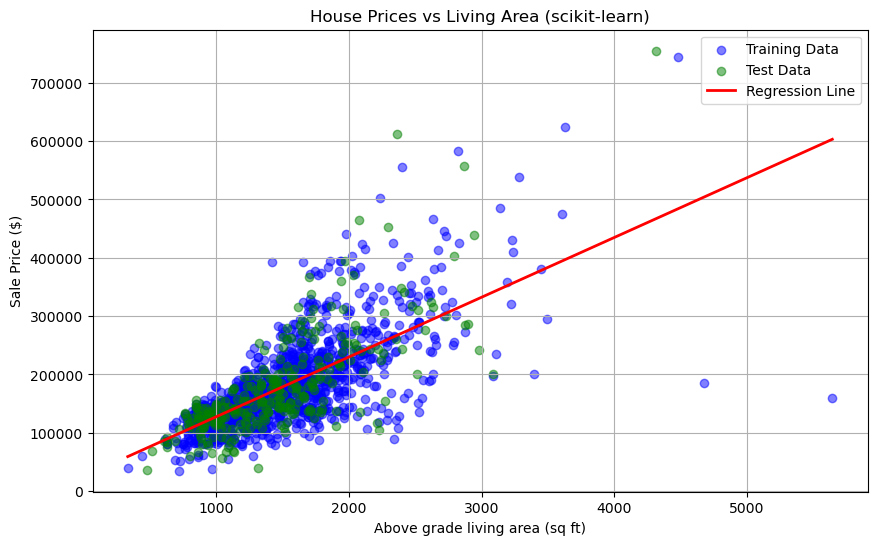

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and prepare the data (same as before)
data = pd.read_csv('train.csv')
X = data['GrLivArea'].values.reshape(-1, 1)
y = data['SalePrice'].values.reshape(-1, 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train scikit-learn's LinearRegression
sk_model = LinearRegression()
sk_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = sk_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Scikit-learn LinearRegression Results:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared: {r2:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.5)
plt.scatter(X_test, y_test, color='green', label='Test Data', alpha=0.5)

x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_line_scaled = scaler.transform(x_line)
y_line = sk_model.predict(x_line_scaled)

plt.plot(x_line, y_line, color='red', linewidth=2, label='Regression Line')
plt.title('House Prices vs Living Area (scikit-learn)')
plt.xlabel('Above grade living area (sq ft)')
plt.ylabel('Sale Price ($)')
plt.legend()
plt.grid(True)
plt.show()

**!! The final comparison of the linear regression model's performance on the house price prediction task, based on the provided metrics and graph, reveals several key insights:**

**1. Model Performance Metrics:**
**MSE (Mean Squared Error): 3,418,946,311.18**

This high value indicates that the model's predictions have substantial squared errors, suggesting it may struggle with accurately predicting house prices, especially for higher-valued homes where errors are penalized more severely.

**MAE (Mean Absolute Error): 38,341.20**

On average, the model's predictions are off by approximately $38,341 from the actual prices. This is a more interpretable metric and confirms that the errors are sizable in absolute terms.
**R-squared (Coefficient of Determination)**: 0.5543

The model explains about 55.43% of the variance in house prices based on living area. While this is better than a baseline model (which would have an R-squared of 0), it leaves nearly 45% of the variance unexplained, indicating room for improvement.

**2. Visualization** (House Prices vs. Living Area):
The graph shows a scatter plot of training and test data points, along with a regression line.

Regression Line Fit: The line appears to capture a general upward trend (higher living area correlates with higher prices), but the wide dispersion of points around the line aligns with the modest R-squared value.

Potential Outliers: Some data points deviate significantly from the line, which may be inflating the MSE/MAE. Investigating outliers or non-linear relationships could help.

**Test vs. Training Data:** The test data points seem to follow a similar pattern to the training data, suggesting the model isn't overfitting (but this depends on the actual distribution, which isn't fully visible).

**3. Key Takeaways:**
The model has moderate predictive power (R-squared ~0.55) but suffers from high prediction errors (MSE/MAE).

The linear relationship between living area and price is evident but not strong enough to fully explain price variations.

**Recommendations for Improvement:**
- Add more features (e.g., location, bedrooms, age of the house) to improve explanatory power.

- Try non-linear models (e.g., polynomial regression or decision trees) if the relationship isn't strictly linear.

- Address outliers or apply transformations (e.g., log-transform prices) if the target variable is skewed.

**Conclusion:**
The model is a reasonable starting point but requires refinement to achieve higher accuracy and better capture the underlying patterns in the data.

